In [1]:
from skimage import data
from skimage.transform import rotate
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Load pickled data
import pickle
import numpy as np
from sklearn.base import BaseEstimator
from sklearn.pipeline import Pipeline

# TODO: Fill this in based on where you saved the training and testing data

training_file = "./traffic-signs-data/train.p"
testing_file = "./traffic-signs-data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
raw_X_train, raw_y_train = train['features'], train['labels']
raw_X_test, raw_y_test = test['features'], test['labels']

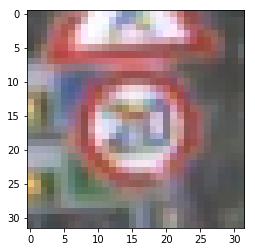

In [3]:
plt.imshow(raw_X_train[0])

In [4]:
def flip_extend(X, y):
    # Classes of signs that, when flipped horizontally, should still be classified as the same class
    self_flippable_horizontally = np.array([11, 12, 13, 15, 17, 18, 22, 26, 30, 35])
    # Classes of signs that, when flipped vertically, should still be classified as the same class
    self_flippable_vertically = np.array([1, 5, 12, 15, 17])
    # Classes of signs that, when flipped horizontally and then vertically, should still be classified as the same class
    self_flippable_both = np.array([32, 40])
    # Classes of signs that, when flipped horizontally, would still be meaningful, but should be classified as some other class
    cross_flippable = np.array([
        [19, 20], 
        [33, 34], 
        [36, 37], 
        [38, 39],
        [20, 19], 
        [34, 33], 
        [37, 36], 
        [39, 38],   
    ])
    num_classes = 43
    
    X_extended = np.empty([0, X.shape[1], X.shape[2], X.shape[3]], dtype = X.dtype)
    y_extended = np.empty([0], dtype = y.dtype)
    
    for c in range(num_classes):
        # First copy existing data for this class
        X_extended = np.append(X_extended, X[y == c], axis = 0)
        # If we can flip images of this class horizontally and they would still belong to said class...
        if c in self_flippable_horizontally:
            # ...Copy their flipped versions into extended array.
            X_extended = np.append(X_extended, X[y == c][:, :, ::-1, :], axis = 0)
        # If we can flip images of this class horizontally and they would belong to other class...
        if c in cross_flippable[:, 0]:
            # ...Copy flipped images of that other class to the extended array.
            flip_class = cross_flippable[cross_flippable[:, 0] == c][0][1]
            X_extended = np.append(X_extended, X[y == flip_class][:, :, ::-1, :], axis = 0)
        # Fill labels for added images set to current class.
        y_extended = np.append(y_extended, np.full((X_extended.shape[0] - y_extended.shape[0]), c, dtype = int))
        
        # If we can flip images of this class vertically and they would still belong to said class...
        if c in self_flippable_vertically:
            # ...Copy their flipped versions into extended array.
            X_extended = np.append(X_extended, X_extended[y_extended == c][:, ::-1, :, :], axis = 0)
        # Fill labels for added images set to current class.
        y_extended = np.append(y_extended, np.full((X_extended.shape[0] - y_extended.shape[0]), c, dtype = int))
        
        # If we can flip images of this class horizontally AND vertically and they would still belong to said class...
        if c in self_flippable_both:
            # ...Copy their flipped versions into extended array.
            X_extended = np.append(X_extended, X_extended[y_extended == c][:, ::-1, ::-1, :], axis = 0)
        # Fill labels for added images set to current class.
        y_extended = np.append(y_extended, np.full((X_extended.shape[0] - y_extended.shape[0]), c, dtype = int))
    
    return (X_extended, y_extended)

In [5]:
def ud_flip(X,y):
    labels=np.array([11, 12, 13, 15, 17, 18, 22, 26, 30, 35,32,40])
    
    idx=np.in1d(y,labels)
    new_X=X[idx,:,::-1,:]
    new_y=y[idx]
    
    return new_X,new_y

In [6]:
def lr_flip(X,y):
    labels=np.array([1, 5, 12, 15, 17,32,40])
    idx=np.in1d(y,labels)
    new_X=X[idx,::-1,:,:]
    new_y=y[idx]
    
    return new_X,new_y

In [7]:
def cross_flip(X,y):
        
    flip_pair=[(19, 20), (33, 34), (36, 37), (38, 39), (20, 19), (34, 33), (37, 36), (39, 38)] 
    
    pair_X=[]
    pair_y=[]
    for fp in flip_pair:
        idx_1= y==fp[0]
        idx_2= y==fp[1]
        
        nX_1=X[idx_1,:,::-1,:]
        ny_1=np.ones(nX_1.shape[0])*fp[1]
        
        nX_2=X[idx_2,:,::-1,:]
        ny_2=np.ones(nX_2.shape[0])*fp[0]
        
        pair_X.append(nX_1)
        pair_X.append(nX_2)
        
        pair_y.append(ny_1)
        pair_y.append(ny_2)
        
    return np.concatenate(pair_X,axis=0),np.concatenate(pair_y,axis=0)


In [8]:
import cv2
def batch_rotate(X):
    for i in range(X.shape[0]):
        img=X[i]
        rows=X.shape[1]
        cols=X.shape[2]
        
        M = cv2.getRotationMatrix2D((cols/2,rows/2),np.random.uniform(-15,15),1)
        X[i] = cv2.warpAffine(img,M,(cols,rows))
    return X  

In [9]:
def warp_image(image,move_range=3):

    # get dimensions of image
    rows,cols,ch = image.shape
    # calculate transform

    start_pt = np.float32([[6, 6],[24, 6],[6, 24]])
    transformed_pt=np.zeros_like(start_pt)
    for idx in range(3):
        lr_move=np.random.randint(-move_range,move_range+1)
        ud_move=np.random.randint(-move_range,move_range+1)
        transformed_pt[idx,0]=start_pt[idx,0]+lr_move
        transformed_pt[idx,1]=start_pt[idx,1]+ud_move


    M = cv2.getAffineTransform(start_pt,transformed_pt)
    warped = cv2.warpAffine(image,M,(cols,rows))

    return warped

def batch_warp(X):
    
    nX=np.zeros_like(X)
    for i in range(X.shape[0]):
        nX[i]=warp_image(X[i])
    
    return nX
        

In [10]:
test_imge=raw_X_train[0]
t_test_image=warp_image(test_imge)

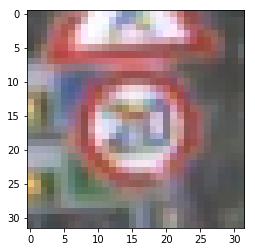

In [11]:
plt.imshow(test_imge)

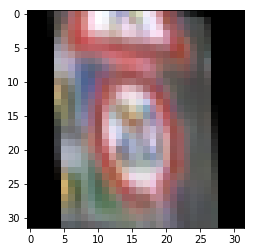

In [12]:
plt.imshow(t_test_image)

In [13]:
nX,ny=ud_flip(raw_X_train,raw_y_train)
uX,uy=lr_flip(raw_X_train,raw_y_train)

In [14]:
fpX,fpy=cross_flip(raw_X_train,raw_y_train)

In [15]:
afX=batch_warp(raw_X_train)
afy=raw_y_train

In [16]:
import copy
rX=batch_rotate(copy.copy(raw_X_train))
ry=raw_y_train
assert rX.shape[0]==ry.shape[0]

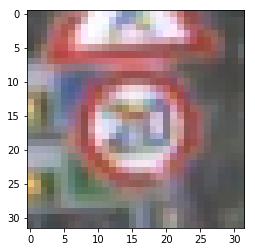

In [17]:
plt.imshow(raw_X_train[0])

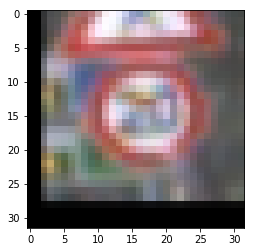

In [18]:
plt.imshow(afX[0])

In [19]:
aug_train={}
aug_train['horiz_sym_features']=nX
aug_train['horiz_sym_labels']=ny
aug_train['vert_sym_features']=uX
aug_train['vert_sym_labels']=uy
aug_train['fp_features']=fpX
aug_train['fp_labels']=fpy
aug_train['rotate_features']=rX
aug_train['rotate_lables']=ry
aug_train['affine_features']=afX
aug_train['affine_labels']=afy
aug_training_file="./traffic-signs-data/aug_train.p"
with open(aug_training_file, mode='wb') as f:
    pickle.dump(aug_train,f)